In [1]:
!pip install praw pandas matplotlib nltk textblob wordcloud

In [2]:
import praw
import pandas as pd
import datetime as dt

# =========================
# 1. Reddit API Credentials
# =========================
# 👉 Replace these with your own keys from https://www.reddit.com/prefs/apps
CLIENT_ID = "#####"
CLIENT_SECRET = "####"
USER_AGENT = "GreenDataAnalysis"

# =========================
# 2. Setup Reddit API Client
# =========================
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

# =========================
# 3. Choose Subreddits
# =========================
subreddits = ["sustainability", "ZeroWaste", "vegan", "BuyItForLife", "DIY"]

# =========================
# 4. Fetch Data
# =========================
posts_data = []

for sub in subreddits:
    subreddit = reddit.subreddit(sub)
    print(f"Fetching posts from r/{sub}...")

    # You can adjust .hot(limit=200), .new(limit=200), .top(limit=200) etc.
    for post in subreddit.hot(limit=2000):  
        post.comments.replace_more(limit=0)  # Flatten "MoreComments"
        comments = [comment.body for comment in post.comments[:20]]  # take first 20 comments only

        posts_data.append({
            "title": post.title,
            "selftext": post.selftext,
            "comments": " || ".join(comments),  # join comments into one string
            "score": post.score,
            "subreddit": sub,
            "created_utc": dt.datetime.fromtimestamp(post.created_utc)
        })

# =========================
# 5. Save to CSV
# =========================
df = pd.DataFrame(posts_data)
df.to_csv("reddit_sustainability_raw.csv", index=False, encoding="utf-8")

print(f"✅ Saved {len(df)} posts to reddit_sustainability_raw.csv")


Fetching posts from r/sustainability...
Fetching posts from r/ZeroWaste...
Fetching posts from r/vegan...
Fetching posts from r/BuyItForLife...
Fetching posts from r/DIY...
✅ Saved 4097 posts to reddit_sustainability_raw.csv


In [3]:
import pandas as pd

# Load dataset
df = pd.read_csv("reddit_sustainability_raw.csv")

print("Shape before cleaning:", df.shape)
print(df.head())


Shape before cleaning: (4097, 6)
                                               title  \
0  With Induction Stoves, Chefs Discover a Foolpr...   
1        Can China’s Green Revolution Be Replicated?   
2  Is there any way to travel overseas without wr...   
3  Could the U.S. Switch to Regenerative Chicken?...   
4    How sustainable are beauty brands really being?   

                                            selftext  \
0  *From Michelin kitchens to home wok burners, i...   
1                                                NaN   
2  My best friend lives in the Phillipines, I'm A...   
3                                                NaN   
4  Lately I’ve been wondering about the beauty in...   

                                            comments  score       subreddit  \
0  *Olivia Rudgard for Bloomberg News*  \n  \nAn ...     91  sustainability   
1  *A new book traces the nation’s path from chok...     47  sustainability   
2  Depending on your metric for “wrecking the pla...    

In [4]:
# Drop duplicates
df.drop_duplicates(inplace=True)

# Drop rows where title or selftext is missing
df.dropna(subset=["title", "selftext"], inplace=True)

print("Shape after removing nulls & duplicates:", df.shape)


Shape after removing nulls & duplicates: (3457, 6)


In [6]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()                                # lowercase
    text = re.sub(r"http\S+|www\S+", "", text)         # remove urls
    text = re.sub(r"[^\w\s]", " ", text)               # remove punctuation
    text = re.sub(r"\d+", "", text)                    # remove numbers
    text = re.sub(r"[^\x00-\x7F]+", " ", text)         # remove emojis/non-ascii
    words = [w for w in text.split() if w not in stop_words]  # remove stopwords
    return " ".join(words)

# Apply cleaning
df["title_clean"] = df["title"].apply(clean_text)
df["selftext_clean"] = df["selftext"].apply(clean_text)
df["comments_clean"] = df["comments"].apply(clean_text)


[nltk_data] Downloading package stopwords to C:\Users\Aditya
[nltk_data]     Raj\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# Define keywords
keywords = ["eco-friendly", "sustainable", "recyclable", "biodegradable", "plastic-free"]

def contains_keywords(text):
    return any(kw in text for kw in keywords)

# Keep posts where title OR selftext OR comments has a keyword
mask = (
    df["title_clean"].apply(contains_keywords) |
    df["selftext_clean"].apply(contains_keywords) |
    df["comments_clean"].apply(contains_keywords)
)

df_filtered = df[mask]
print("Shape after keyword filtering:", df_filtered.shape)

# Save clean dataset
df_filtered.to_csv("reddit_sustainability_clean.csv", index=False, encoding="utf-8")
print("✅ Clean dataset saved as reddit_sustainability_clean.csv")


Shape after keyword filtering: (391, 9)
✅ Clean dataset saved as reddit_sustainability_clean.csv


In [8]:
import pandas as pd

df = pd.read_csv("reddit_sustainability_clean.csv")
print("Dataset size:", df.shape)
print(df.head())


Dataset size: (391, 9)
                                               title  \
0    How sustainable are beauty brands really being?   
1   Plastic bottle shelters popping up across Africa   
2  Is there any way for me to sustainably go to L...   
3  Amazon really our here claiming they are a sus...   
4                        Classroom Cleaning Solution   

                                            selftext  \
0  Lately I’ve been wondering about the beauty in...   
1  Across sub-Saharan Africa, discarded bottles a...   
2  Hi, ik this is a weird question but next year ...   
3  Ordered 2 packs of tiny key rings in the same ...   
4  Hi everyone! I’m going to be a first year teac...   

                                            comments  score       subreddit  \
0  I don't trust beauty brands for *any* claims t...      1  sustainability   
1  What happens when the plastic bottles lose the...   1052  sustainability   
2  Rail and sail ticket from Dublin or Rosslare g...      9  susta

[('use', 1503), ('like', 1364), ('plastic', 1234), ('waste', 922), ('one', 869), ('also', 859), ('get', 821), ('make', 753), ('would', 683), ('buy', 681), ('people', 655), ('things', 655), ('good', 599), ('need', 569), ('sustainable', 526), ('really', 515), ('much', 514), ('vegan', 505), ('paper', 497), ('think', 489)]


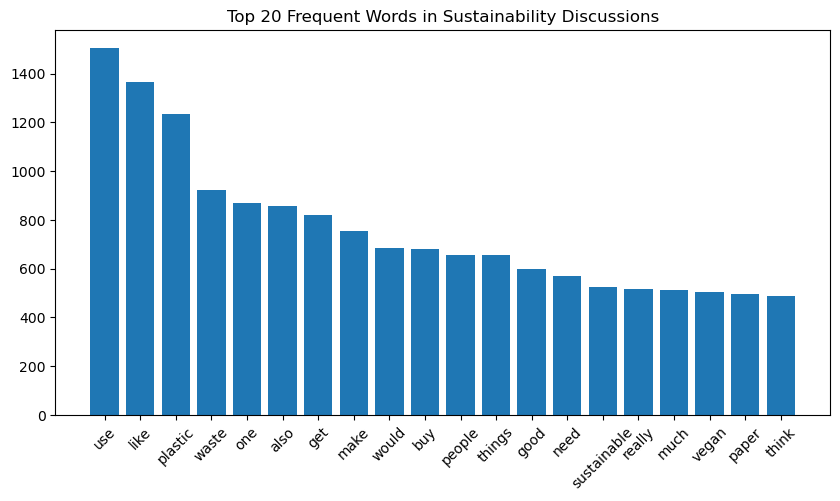

In [9]:
from collections import Counter

# Combine all text fields
all_text = " ".join(df["title_clean"].astype(str) + " " +
                    df["selftext_clean"].astype(str) + " " +
                    df["comments_clean"].astype(str))

# Split words
words = all_text.split()

# Count frequencies
word_freq = Counter(words)

# Get top 20 words
top_words = word_freq.most_common(20)
print(top_words)

# Plot
import matplotlib.pyplot as plt

words, counts = zip(*top_words)
plt.figure(figsize=(10,5))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title("Top 20 Frequent Words in Sustainability Discussions")
plt.show()


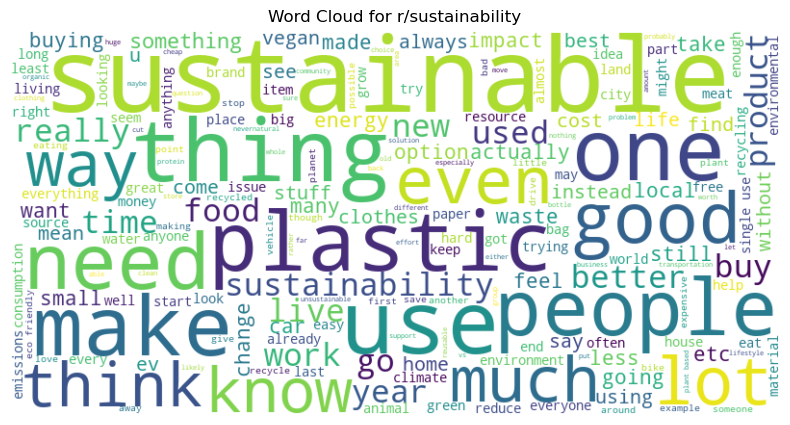

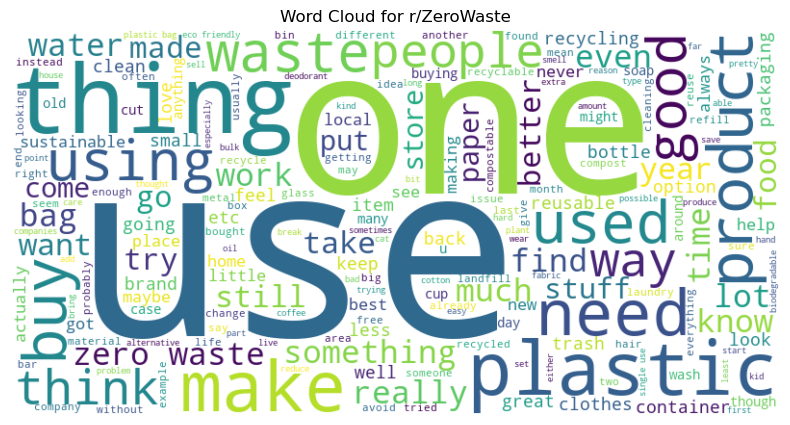

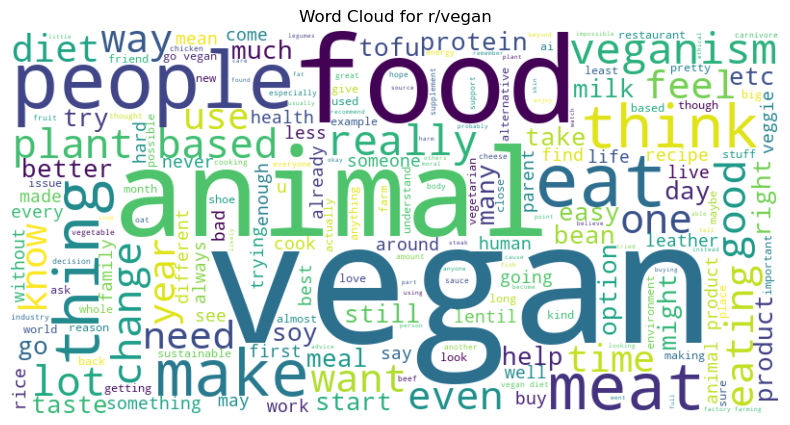

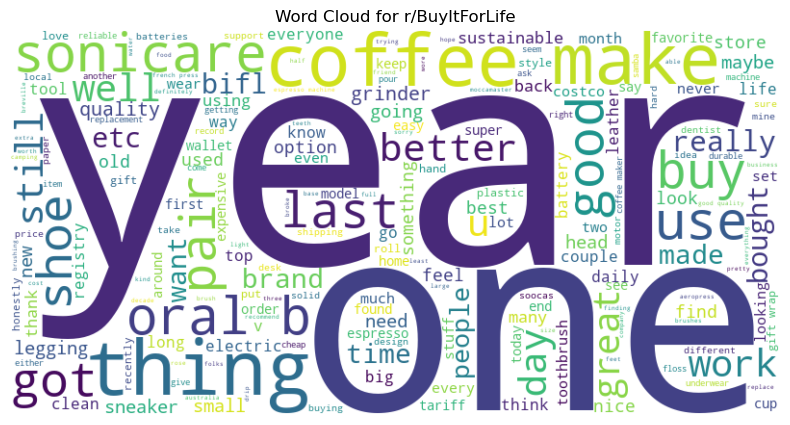

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

subreddits = df["subreddit"].unique()

for sub in subreddits:
    sub_text = " ".join(df[df["subreddit"] == sub]["title_clean"].astype(str) +
                        df[df["subreddit"] == sub]["selftext_clean"].astype(str) +
                        df[df["subreddit"] == sub]["comments_clean"].astype(str))

    wc = WordCloud(width=800, height=400, background_color="white").generate(sub_text)
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for r/{sub}")
    plt.show()


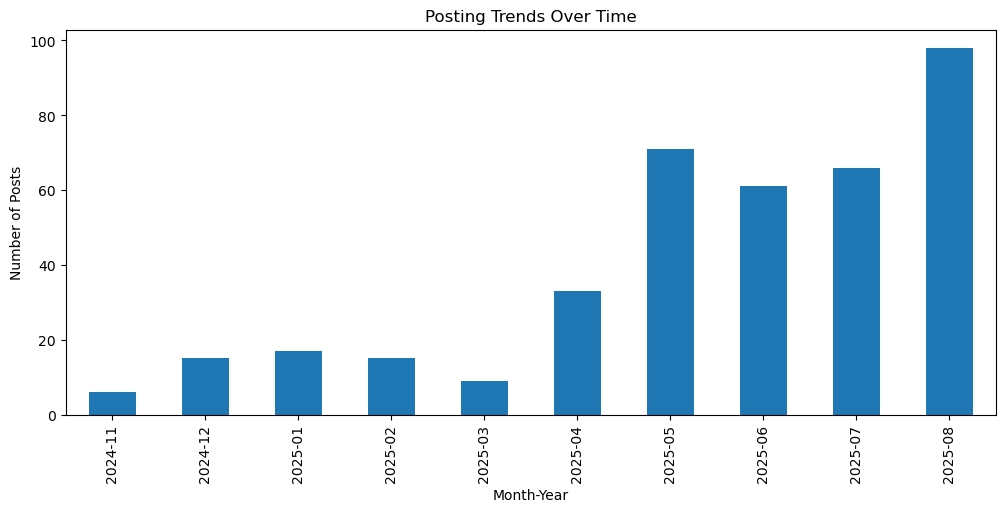

In [11]:
# Convert created_utc to datetime
df["created_utc"] = pd.to_datetime(df["created_utc"])

# Group by month/year
df["month_year"] = df["created_utc"].dt.to_period("M")
trend = df.groupby("month_year").size()

# Plot
trend.plot(kind="bar", figsize=(12,5))
plt.title("Posting Trends Over Time")
plt.xlabel("Month-Year")
plt.ylabel("Number of Posts")
plt.show()


Average Upvotes per Keyword: {'eco-friendly': nan, 'sustainable': 185.85401459854015, 'recyclable': 87.43859649122807, 'biodegradable': 90.14754098360656, 'plastic-free': nan}


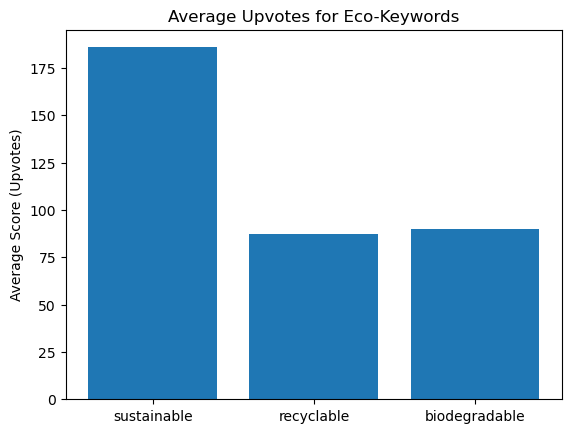

In [12]:
keywords = ["eco-friendly", "sustainable", "recyclable", "biodegradable", "plastic-free"]

engagement = {}

for kw in keywords:
    mask = df["title_clean"].str.contains(kw) | df["selftext_clean"].str.contains(kw) | df["comments_clean"].str.contains(kw)
    avg_score = df[mask]["score"].mean()
    engagement[kw] = avg_score

print("Average Upvotes per Keyword:", engagement)

# Plot
plt.bar(engagement.keys(), engagement.values())
plt.title("Average Upvotes for Eco-Keywords")
plt.ylabel("Average Score (Upvotes)")
plt.show()
